In [1]:
# Importing requiredlibraries
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import xception
tf.__version__

2021-10-01 12:19:13.995174: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


'2.4.1'

In [2]:
# train and valid data path
train_path = '../input/tomato/New Plant Diseases Dataset(Augmented)/train'
valid_path = '../input/tomato/New Plant Diseases Dataset(Augmented)/valid'

In [3]:
# Creating Dataset Generators using flow_from_directory method of ImageDataGenerator
train_datagen = ImageDataGenerator(preprocessing_function=xception.preprocess_input, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True)
valid_datagen = ImageDataGenerator(preprocessing_function=xception.preprocess_input)

In [4]:
train_set = train_datagen.flow_from_directory(train_path, 
                                              target_size=(224, 224), 
                                              batch_size=32, 
                                              class_mode='categorical')

Found 18345 images belonging to 10 classes.


In [5]:
valid_set = valid_datagen.flow_from_directory(valid_path, 
                                              target_size=(224, 224), 
                                              batch_size=32, 
                                              class_mode='categorical')

Found 4585 images belonging to 10 classes.


In [6]:
# Classes and their corresponding indices in prediction array
train_set.class_indices

{'Tomato___Bacterial_spot': 0,
 'Tomato___Early_blight': 1,
 'Tomato___Late_blight': 2,
 'Tomato___Leaf_Mold': 3,
 'Tomato___Septoria_leaf_spot': 4,
 'Tomato___Spider_mites Two-spotted_spider_mite': 5,
 'Tomato___Target_Spot': 6,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 7,
 'Tomato___Tomato_mosaic_virus': 8,
 'Tomato___healthy': 9}

In [7]:
# Final image shape before passing to model
train_set.image_shape

(224, 224, 3)

In [8]:
# Model building using transfer learning(base model: pretrained Xception)
base_model = xception.Xception(input_shape= [224, 224, 3], weights='imagenet', include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(10, activation='softmax')(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

2021-10-01 12:19:27.032746: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-01 12:19:27.036209: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-01 12:19:27.079792: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-01 12:19:27.080525: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-01 12:19:27.080592: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-01 12:19:27.105413: I tensorflow/stream_executor/platform/def

83689472/83683744 [==============================] - 1s 0us/step


In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [10]:
# Freezing bottom layers to preserve reused weights from large error gradients
for layer in base_model.layers:
    layer.trainable = False

preoptimizer = keras.optimizers.SGD(learning_rate=0.1)
model.compile(loss='categorical_crossentropy', optimizer=preoptimizer, metrics=['accuracy'])

In [11]:
history = model.fit(
    train_set, 
    epochs=15, 
    validation_data=valid_set,
    steps_per_epoch=len(train_set),
    validation_steps=len(valid_set)
)

2021-10-01 12:19:32.021144: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-01 12:19:32.026041: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000165000 Hz


Epoch 1/15


2021-10-01 12:19:34.414486: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-01 12:19:35.213250: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-01 12:19:35.237340: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


574/574 [==============================] - 340s 578ms/step - loss: 1.1916 - accuracy: 0.6101 - val_loss: 0.6210 - val_accuracy: 0.7952
Epoch 2/15
574/574 [==============================] - 238s 415ms/step - loss: 0.5891 - accuracy: 0.8054 - val_loss: 0.5458 - val_accuracy: 0.8120
Epoch 3/15
574/574 [==============================] - 240s 419ms/step - loss: 0.5022 - accuracy: 0.8367 - val_loss: 0.4718 - val_accuracy: 0.8465
Epoch 4/15
574/574 [==============================] - 238s 415ms/step - loss: 0.4494 - accuracy: 0.8571 - val_loss: 0.4694 - val_accuracy: 0.8449
Epoch 5/15
574/574 [==============================] - 239s 415ms/step - loss: 0.4253 - accuracy: 0.8579 - val_loss: 0.4403 - val_accuracy: 0.8495
Epoch 6/15
574/574 [==============================] - 238s 414ms/step - loss: 0.3952 - accuracy: 0.8706 - val_loss: 0.4029 - val_accuracy: 0.8672
Epoch 7/15
574/574 [==============================] - 238s 415ms/step - loss: 0.3765 - accuracy: 0.8732 - val_loss: 0.4131 - val_accura

In [12]:
# Now unfreezing to train the complete model
# Using callback to save only the best model and early-stopping to save some time
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.Nadam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint("disease_classifier_over_xception.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [13]:
history = model.fit(
    train_set, 
    epochs=100, 
    validation_data=valid_set,
    steps_per_epoch=len(train_set),
    validation_steps=len(valid_set),
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/100
574/574 [==============================] - 338s 569ms/step - loss: 0.3346 - accuracy: 0.8865 - val_loss: 0.0781 - val_accuracy: 0.9723
Epoch 2/100
574/574 [==============================] - 328s 570ms/step - loss: 0.0455 - accuracy: 0.9847 - val_loss: 0.0339 - val_accuracy: 0.9880
Epoch 3/100
574/574 [==============================] - 327s 569ms/step - loss: 0.0299 - accuracy: 0.9903 - val_loss: 0.0187 - val_accuracy: 0.9943
Epoch 4/100
574/574 [==============================] - 343s 597ms/step - loss: 0.0189 - accuracy: 0.9931 - val_loss: 0.0256 - val_accuracy: 0.9911
Epoch 5/100
574/574 [==============================] - 332s 579ms/step - loss: 0.0196 - accuracy: 0.9941 - val_loss: 0.0411 - val_accuracy: 0.9889
Epoch 6/100
574/574 [==============================] - 332s 578ms/step - loss: 0.0156 - accuracy: 0.9951 - val_loss: 0.0476 - val_accuracy: 0.9878
Epoch 7/100
574/574 [==============================] - 344s 598ms/step - loss: 0.0173 - accuracy: 0.9942 - val_loss: 0

In [14]:
import pandas as pd


Minimum validation loss: 0.006888397503644228

Accuracy achieved on validation data: 0.9978189468383789



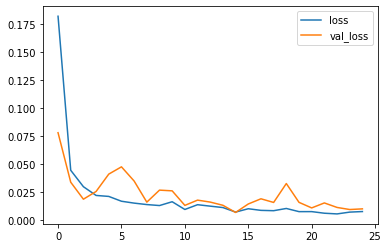

In [15]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("\nMinimum validation loss: {}".format(history_df['val_loss'].min()))
print("\nAccuracy achieved on validation data: {}\n".format(history_df['val_accuracy'][len(history_df)-11]))